In [1]:
from __future__ import annotations

from typing import Union, List, Tuple, Optional
from dataclasses import dataclass

import numpy as np
import pandas as pd
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_X_y, check_array
from sklearn.utils.multiclass import type_of_target
from scipy.special import betaln, gammaln, digamma
import requests
from matplotlib.colors import Colormap
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing

In [2]:

ARRAY_OR_FLOAT = Union[np.ndarray, float]
def multivariate_betaln(alphas: np.ndarray) -> ARRAY_OR_FLOAT:
    if len(alphas) == 2:
        return betaln(alphas[0], alphas[1])
    else:
        # see https://en.wikipedia.org/wiki/Beta_function#Multivariate_beta_function
        return np.sum([gammaln(alpha) for alpha in alphas], axis=0) - gammaln(alphas.sum())


def compute_log_p_data(
        prior: np.ndarray,
        k: Union[np.ndarray, float],
        betaln_prior: float) -> Union[np.ndarray, float]:
    # see https://www.cs.ubc.ca/~murphyk/Teaching/CS340-Fall06/reading/bernoulli.pdf, equation (42)
    # which can be expressed as a fraction of beta functions
    posterior = prior + k
    return multivariate_betaln(posterior.T) - betaln_prior


def d_log_multivariate_beta_d_alphas(alphas: np.ndarray) -> ARRAY_OR_FLOAT:
    return digamma(alphas) - digamma(np.sum(alphas))


def sigmoid(x: ARRAY_OR_FLOAT) -> ARRAY_OR_FLOAT:
    # avoid underflow/overflow
    LOW = -708
    HIGH = 40

    if np.isscalar(x):
        return 1 if x > HIGH else 0 if x < LOW else 1 / (1 + np.exp(-x))
    else:
        lt_40 = x <= HIGH
        gt_m708 = x >= LOW
        if np.all(lt_40) and np.all(gt_m708):
            return 1 / (1 + np.exp(-x))
        else:
            result = np.zeros(x.shape)
            result[~lt_40] = 1
            valid = np.where(lt_40 & gt_m708)[0]
            result[valid] = 1 / (1 + np.exp(-x[valid]))
            return result


def pick_proportional(relative_probabilities: np.ndarray):
    # from page 161 of
    # https://github.com/Grant6899/books/blob/master/%5BMark%20Joshi%5DQuant%20Job%20Interview%20Questions%20And%20Answers.pdf
    p = relative_probabilities / np.sum(relative_probabilities)
    u = np.random.uniform(0, 1)
    i = 0
    while u > p[i]:
        u -= p[i]
        i += 1

    return i

In [3]:

# Adam optimizer settings (see https://arxiv.org/abs/1412.6980)
BETA_1_ADAM = 0.9
BETA_2_ADAM = 0.999
EPS_ADAM = 1e-8


# Note: The following three methods must adhere to the same node iteration order
# in order to avoid weight vectors getting wrongly assigned to nodes:
#
# - _collect_weight_matrix
# - _distribute_weight_matrix
# - _compute_d_err_d_s_hat_and_collect_d_err_d_weights


@dataclass
class Node:
    """
    A node in the adaptive Bayesian reticulum tree.
    """
    level: int

    left__child: Optional[Node] = None
    right_child: Optional[Node] = None

    weights: Optional[np.ndarray] = None

    s: Optional[np.ndarray] = None
    s_hat_left_: Optional[np.ndarray] = None
    s_hat_right: Optional[np.ndarray] = None

    k_left_: Optional[int] = None
    k_right: Optional[int] = None

    posterior_left_: Optional[np.ndarray] = None
    posterior_right: Optional[np.ndarray] = None

    log_p_data_left_: float = None
    log_p_data_right: float = None

    log_p_data_split = None
    log_p_data_no_split = None

    def try_fit(
            self,
            Xa: np.ndarray,
            y: np.ndarray,
            prior: np.ndarray,
            s_hat_parent: Optional[np.ndarray],
            learning_rate_init: float,
            n_gradient_descent_steps: Optional[int],
            initial_relative_stiffness: Optional[float]) -> bool:
        if s_hat_parent is None:
            n_data = Xa.shape[0]
            s_hat_parent = np.ones(n_data)

        # 1. initialize weights (if required)
        if self.weights is not None:
            # use weights that are already set on this node
            initial_weights = self.weights
        else:
            # initialize by choosing a random weight vector
            initial_weights = self._initialize_weights(
                Xa=Xa,
                s_hat_parent=s_hat_parent,
                initial_relative_stiffness=initial_relative_stiffness)

        if initial_weights is not None:
            self.weights = initial_weights
        else:
            # no data that we could split
            return False

        # 2. optimize weights of newly added node using gradient descent (i.e., local optimization)
        self._perform_gradient_descent(
            Xa=Xa,
            y=y,
            s_hat_parent=s_hat_parent,
            learning_rate_init=learning_rate_init,
            n_gradient_descent_steps=n_gradient_descent_steps,
            prior=prior)

        # 3. compute log-likelihoods of not splitting vs. splitting
        log_p_data_no_split = self._compute_log_p_data_no_split(y, s_hat_parent, prior)
        self.update_log_p_data_soft_split(Xa, y, s_hat_parent, prior, recursive=False)
        log_p_data_split = self.log_p_data_left_ + self.log_p_data_right

        # keep and complete
        self.posterior_left_ = prior + self.k_left_
        self.posterior_right = prior + self.k_right
        self.log_p_data_split = log_p_data_split
        self.log_p_data_no_split = log_p_data_no_split

        return True

    def try_prune(
            self,
            Xa: np.ndarray,
            y: np.ndarray,
            prior: np.ndarray,
            pruning_factor: float,
            verbose: bool,
            s_hat_parent: Optional[np.ndarray]=None) -> Tuple[bool, bool]:
        any_child_pruned = False

        # recursively try pruning children first because actual pruning must start at the leaf level
        if self.left__child is not None:
            left_child_pruned, any_child_of_left_child_pruned = self.left__child.try_prune(
                Xa=Xa,
                y=y,
                prior=prior,
                pruning_factor=pruning_factor,
                verbose=verbose,
                s_hat_parent=self.s_hat_left_)

            if left_child_pruned:
                self.left__child = None

            any_child_pruned |= left_child_pruned
            any_child_pruned |= any_child_of_left_child_pruned

        if self.right_child is not None:
            right_child_pruned, any_child_of_right_child_pruned = self.right_child.try_prune(
                Xa=Xa,
                y=y,
                prior=prior,
                pruning_factor=pruning_factor,
                verbose=verbose,
                s_hat_parent=self.s_hat_right)

            if right_child_pruned:
                self.right_child = None

            any_child_pruned |= right_child_pruned
            any_child_pruned |= any_child_of_right_child_pruned

        # now try pruning this node if it has no children (either because it never had or because they just got pruned)
        if self.left__child is None and self.right_child is None:
            if s_hat_parent is None:
                n_data = Xa.shape[0]
                s_hat_parent = np.ones(n_data)

            # check if this split is adding value
            pruning_factor_for_level = pruning_factor**(self.level+1)
            log_p_data_no_split = self._compute_log_p_data_no_split(y, s_hat_parent, prior)
            log_p_data_split = self.log_p_data_left_ + self.log_p_data_right
            if log_p_data_split <= log_p_data_no_split + np.log(pruning_factor_for_level):
                # this split isn't adding value (anymore) -> prune
                if verbose:
                    print(f'Pruning node at level {self.level}')

                return True, any_child_pruned

        # check if this split is actually splitting data
        activation = Xa @ self.weights
        if np.all(activation < 0) or np.all(activation > 0):
            # all data on one side -> not actually splitting anything
            return True, any_child_pruned

        return False, any_child_pruned

    def update_probability(self, Xa: np.ndarray, p: np.ndarray) -> None:
        if self.left__child is None:
            p += self.s_hat_left_.reshape(-1, 1) @ self.predict_proba_leaf_left_().reshape(1, -1)
        else:
            self.left__child.update_probability(Xa, p)

        if self.right_child is None:
            p += self.s_hat_right.reshape(-1, 1) @ self.predict_proba_leaf_right().reshape(1, -1)
        else:
            self.right_child.update_probability(Xa, p)

    def collect_terminal_nodes(self, is_left: bool, nodes: List[Node]=None) -> List[Node]:
        if nodes is None:
            nodes = []

        if self.left__child:
            self.left__child.collect_terminal_nodes(is_left, nodes)
        elif is_left:
            nodes.append(self)

        if self.right_child:
            self.right_child.collect_terminal_nodes(is_left, nodes)
        elif not is_left:
            nodes.append(self)

        return nodes

    @staticmethod
    def _initialize_weights(
            Xa: np.ndarray,
            s_hat_parent: np.ndarray,
            initial_relative_stiffness: float) -> Optional[np.ndarray]:
        assert s_hat_parent.ndim == 1

        n_dim = Xa.shape[1]-1  # ignore the augmented offset dimension

        # remove data points that have a too low weight
        keep_condition = s_hat_parent >= 0.5
        Xa = Xa[keep_condition, :]
        if len(Xa) < 2:
            # no point in splitting data sets with less than two points
            return None

        # compute outlier-resistant data range and compute weight scaling
        half_range = np.quantile(Xa[:, 1:], 0.75, axis=0) - np.quantile(Xa[:, 1:], 0.25, axis=0)
        zeros = half_range == 0
        if np.any(zeros):
            # first fix for zero entries: use half of the full range
            half_range[zeros] = (0.5 * (np.max(Xa[:, 1:], axis=0) - np.min(Xa[:, 1:], axis=0)))[zeros]

        zeros = half_range == 0
        if np.any(zeros):
            # second fix for zero entries: use 1
            half_range[zeros] = 1

        sd = 1/half_range

        # choose random initial weight appropriately scaled to the data
        weights = np.random.normal(0, 1, n_dim)
        weights /= np.linalg.norm(weights)
        weights *= sd

        # center the weight vector at the median of the data
        median = np.median(Xa[:, 1:], axis=0)
        weights = np.insert(weights, 0, 0)
        weights[0] = -np.dot(median, weights[1:])

        # apply initial stiffness
        return weights * initial_relative_stiffness

    def _perform_gradient_descent(
            self,
            Xa: np.ndarray,
            y: np.ndarray,
            s_hat_parent: np.ndarray,
            learning_rate_init: float,
            n_gradient_descent_steps: int,
            prior: np.ndarray) -> None:
        weight_matrix = self._collect_weight_matrix()
        momentum = 0
        velocity = 0

        if hasattr(self, 'callback') and hasattr(self, 'root'):
            self.callback('gd_start', self.root, self)

        for i in range(n_gradient_descent_steps):
            gradient = self._compute_d_err_d_weights(Xa=Xa, y=y, prior=prior, s_hat_parent=s_hat_parent)

            momentum = BETA_1_ADAM * momentum + (1 - BETA_1_ADAM) * gradient
            velocity = BETA_2_ADAM * velocity + (1 - BETA_2_ADAM) * gradient**2
            momentum_hat = momentum/(1 - BETA_1_ADAM**(i + 1))
            velocity_hat = velocity/(1 - BETA_2_ADAM**(i + 1))

            weight_matrix -= learning_rate_init * momentum_hat / (np.sqrt(velocity_hat) + EPS_ADAM)
            self._distribute_weight_matrix(weight_matrix)

        if hasattr(self, 'callback') and hasattr(self, 'root'):
            self.callback('gd_end', self.root, self)

    def update_s_hat(
            self, Xa: np.ndarray,
            s_hat_parent: Optional[np.ndarray]=None) -> None:
        if s_hat_parent is None:
            n_data = Xa.shape[0]
            s_hat_parent = np.ones(n_data)

        # compute left and right node outputs
        self.s = sigmoid(Xa @ self.weights)
        self.s_hat_left_ = s_hat_parent * self.s
        self.s_hat_right = s_hat_parent * (1-self.s)

        # recursively call children
        if self.left__child is not None:
            self.left__child.update_s_hat(Xa, self.s_hat_left_)

        if self.right_child is not None:
            self.right_child.update_s_hat(Xa, self.s_hat_right)

    def _compute_d_err_d_weights(
            self,
            Xa: np.ndarray,
            y: np.ndarray,
            prior: np.ndarray,
            s_hat_parent: np.ndarray) -> np.ndarray:
        # recursive forward pass
        self.update_s_hat(Xa, s_hat_parent)

        # recursive backward pass
        class_idx = [y == i for i in range(len(np.unique(y)))]
        d_k_d_s_hat = np.vstack([1*ci for ci in class_idx])

        d_err_d_weights_list = []
        self._compute_d_err_d_s_hat_and_collect_d_err_d_weights(
            Xa, prior, s_hat_parent, class_idx, d_k_d_s_hat, d_err_d_weights_list)

        return np.vstack(d_err_d_weights_list).T

    def _compute_d_err_d_s_hat_and_collect_d_err_d_weights(
            self,
            Xa: np.ndarray,
            prior: np.ndarray,
            s_hat_parent: np.ndarray,
            class_idx: List[np.ndarray],
            d_k_d_s_hat: np.ndarray,
            d_err_d_weights_list: List[np.ndarray]) -> np.ndarray:
        # see node iteration order note at the top of this file

        if self.left__child is None:
            # leaf on the left
            k_left_ = np.array([self.s_hat_left_[ci].sum() for ci in class_idx])
            posterior_left_ = prior + k_left_
            d_err_d_k_left_ = -d_log_multivariate_beta_d_alphas(posterior_left_)
            d_err_d_s_hat_left_ = d_err_d_k_left_ @ d_k_d_s_hat
        else:
            # child node on the left
            d_err_d_s_hat_left_ = self.left__child._compute_d_err_d_s_hat_and_collect_d_err_d_weights(
                Xa=Xa,
                prior=prior,
                s_hat_parent=self.s_hat_left_,
                class_idx=class_idx,
                d_k_d_s_hat=d_k_d_s_hat,
                d_err_d_weights_list=d_err_d_weights_list)

        if self.right_child is None:
            # leaf on the left
            k_right = np.array([self.s_hat_right[ci].sum() for ci in class_idx])
            posterior_right = prior + k_right
            d_err_d_k_right = -d_log_multivariate_beta_d_alphas(posterior_right)
            d_err_d_s_hat_right = d_err_d_k_right @ d_k_d_s_hat
        else:
            # child node on the left
            d_err_d_s_hat_right = self.right_child._compute_d_err_d_s_hat_and_collect_d_err_d_weights(
                Xa=Xa,
                prior=prior,
                s_hat_parent=self.s_hat_right,
                class_idx=class_idx,
                d_k_d_s_hat=d_k_d_s_hat,
                d_err_d_weights_list=d_err_d_weights_list)

        d_s_hat_left__ds = s_hat_parent
        d_s_hat_right_ds = -s_hat_parent
        d_err_d_s = d_err_d_s_hat_left_ * d_s_hat_left__ds + d_err_d_s_hat_right * d_s_hat_right_ds
        d_err_d_s_hat_parent = d_err_d_s_hat_left_ * self.s + d_err_d_s_hat_right * (1-self.s)
        d_s_d_a = self.s*(1-self.s)
        d_err_d_weights = (d_err_d_s * d_s_d_a) @ Xa
        d_err_d_weights_list.append(d_err_d_weights)

        return d_err_d_s_hat_parent

    def update_log_p_data_soft_split(
            self,
            Xa: np.ndarray,
            y: np.ndarray,
            s_hat_parent: np.ndarray,
            prior: np.ndarray,
            recursive: bool) -> None:
        assert Xa.shape[0] == len(y)
        assert s_hat_parent.ndim == 1

        class_idx = [y == i for i in range(len(np.unique(y)))]

        self.s = sigmoid(Xa @ self.weights)

        self.s_hat_left_ = s_hat_parent * self.s
        self.s_hat_right = s_hat_parent * (1 - self.s)

        self.k_left_ = Node._compute_k(self.s_hat_left_, class_idx).T
        self.k_right = Node._compute_k(self.s_hat_right, class_idx).T

        betaln_prior = multivariate_betaln(prior)
        self.log_p_data_left_ = compute_log_p_data(prior, self.k_left_, betaln_prior)
        self.log_p_data_right = compute_log_p_data(prior, self.k_right, betaln_prior)

        if recursive:
            if self.left__child:
                self.left__child.update_log_p_data_soft_split(Xa, y, self.s_hat_left_, prior, recursive)

            if self.right_child:
                self.right_child.update_log_p_data_soft_split(Xa, y, self.s_hat_right, prior, recursive)

    @staticmethod
    def _compute_log_p_data_no_split(
            y: np.ndarray,
            s_hat_parent: np.ndarray,
            prior: np.ndarray) -> np.ndarray:
        class_idx = [y == i for i in range(len(np.unique(y)))]
        k = Node._compute_k(s_hat_parent, class_idx).T
        betaln_prior = multivariate_betaln(prior)
        return compute_log_p_data(prior, k, betaln_prior)

    @staticmethod
    def _compute_k(s_hat: np.ndarray, class_idx: List[np.array]) -> np.ndarray:
        return np.array([s_hat[ci].sum(axis=0) for ci in class_idx])

    def _collect_weight_matrix(self, weights_list: List[np.ndarray]=None) -> Optional[np.ndarray]:
        # see node iteration order note at the top of this file

        if weights_list is None:
            weights_list = []
            return_matrix = True
        else:
            return_matrix = False

        if self.left__child is not None:
            self.left__child._collect_weight_matrix(weights_list)

        if self.right_child is not None:
            self.right_child._collect_weight_matrix(weights_list)

        weights_list.append(self.weights)

        if return_matrix:
            return np.array(weights_list).T

    def _distribute_weight_matrix(self, weight_matrix: np.ndarray, index: Optional[int]=None) -> int:
        # see node iteration order note at the top of this file

        if index is None:
            index = 0

        if self.left__child is not None:
            index = self.left__child._distribute_weight_matrix(weight_matrix, index)

        if self.right_child is not None:
            index = self.right_child._distribute_weight_matrix(weight_matrix, index)

        self.weights = weight_matrix[:, index]
        index += 1

        # now that the weights have changed the node is potentially splittable once again
        self.left__is_splittable = True
        self.right_is_splittable = True

        return index

    def update_depth(self, depth: int) -> int:
        depth = max(depth, self.level+1)

        if self.left__child is not None:
            depth = self.left__child.update_depth(depth)

        if self.right_child is not None:
            depth = self.right_child.update_depth(depth)

        return depth

    def update_n_leaves(self, n_leaves: int) -> int:
        if self.left__child is None:
            n_leaves += 1
        else:
            n_leaves = self.left__child.update_n_leaves(n_leaves)

        if self.right_child is None:
            n_leaves += 1
        else:
            n_leaves = self.right_child.update_n_leaves(n_leaves)

        return n_leaves

    def update_feature_importance(self, feature_importance: np.ndarray) -> None:
        # the more the normal vector is oriented along a given dimension's axis the
        # more important that dimension is, so weight the gain in log-likelihood by
        # the absolute value of the unit hyperplane normal
        log_p_gain = self.log_p_data_split - self.log_p_data_no_split
        hyperplane_normal = self.weights[1:] / np.linalg.norm(self.weights[1:])
        feature_importance += log_p_gain * np.abs(hyperplane_normal)

        if self.left__child is not None:
            self.left__child.update_feature_importance(feature_importance)

        if self.right_child is not None:
            self.right_child.update_feature_importance(feature_importance)

    def predict_proba_leaf_left_(self) -> np.ndarray:
        if self.posterior_left_ is None:
            return np.nan

        return self.posterior_left_ / self.posterior_left_.sum()

    def predict_proba_leaf_right(self) -> np.ndarray:
        if self.posterior_right is None:
            return np.nan

        return self.posterior_right / self.posterior_right.sum()

    def get_n_data(self) -> float:
        return self.k_left_.sum() + self.k_right.sum()

    def __str__(self) -> str:
        return self._str('', '')

    def _str(self, prefix: str, children_prefix: str) -> str:
        s = prefix

        # choose hyperplane origin to be the closest point to the origin
        weights = self.weights
        normal = weights[1:]
        origin = normal * -weights[0] / np.dot(normal, normal)
        origin_str = np.array2string(origin, max_line_width=9999, separator=', ', floatmode='maxprec_equal')
        normal_str = np.array2string(normal, max_line_width=9999, separator=', ', floatmode='maxprec_equal')
        s += f'origin={origin_str}, normal={normal_str}'
        s += '\n'

        child_prefix_left_ = children_prefix + '├─ left: '
        child_prefix_right = children_prefix + '└─ right:'
        if self.left__child is not None:
            s += self.left__child._str(child_prefix_left_, children_prefix + '│  ')
        else:
            s += f'{child_prefix_left_} p(y)={self.predict_proba_leaf_left_()}, n={self.k_left_.sum()}\n'

        if self.right_child is not None:
            s += self.right_child._str(child_prefix_right, children_prefix + '   ')
        else:
            s += f'{child_prefix_right} p(y)={self.predict_proba_leaf_right()}, n={self.k_right.sum()}\n'

        return s


In [4]:
# types
INPUT = Union[np.ndarray, pd.DataFrame, List[List[float]]]
TARGET = Union[np.ndarray, List[float]]


class AdaptiveBayesianReticulum(BaseEstimator, ClassifierMixin):
    """
    The Adaptive Bayesian Reticulum classification model for binary and
    multiclass classification.

    Parameters
    ----------

    prior : tuple, shape = [n_classes], optional, default=(number of instances of each class divided by 20)
        The hyperparameters (alpha_0, alpha_1, ..., alpha_[N-1]) of the Dirichlet
        conjugate prior, see [1] and [2]. All alpha_i must be positive, where
        alpha_i represents the number of prior pseudo-observations of class i.
        Defaults to 1/20 times the number of observations in each class, i.e.,
        5 % prior strength. If the problem is binary classification then the
        theDirichlet distribution collapses to a Beta distribution with an
        (alpha, beta) prior.

    pruning_factor : float, optional, default=1.05
        The factor by which the log likelihood of a split has to be larger than
        the log likelihood of no split in order to keep the split during the
        pruning stage. Larger values lead to more aggressive pruning and may
        lead to underfitting, while small values encourage model complexity and
        may lead to overfitting. The value provided must be >= 1.

    n_iter : int, default=50
        The number of attempts to add new nodes by splitting
        existing ones. The resulting tree will at most contain n_iter nodes, but
        it may contain less due to pruning. Larger values lead to
        more complex and expressive models at the cost of potentially overfitting
        and slower training performance, while smaller values restrict model
        complexity and training time but can lead to underfitting.

    learning_rate_init : float, optional, default=1e-4
        The initial gradient descent learning rate. We use the adaptive 'Adam'
        gradient descent method, see [3] and [4].

    n_gradient_descent_steps : int, optional, default=100
        The number of gradient descent steps to perform in each iteration. Half
        of the steps will perform local gradient descent on only the newly added
        node and half will be applied during global gradient descent involving
        the whole tree.

    initial_relative_stiffness : float
        The initial stiffness of the problem, see the paper for an explanation of
        'stiffness'. Small values (0.1...5) represent "soft" splits allowing for
        further optimization through gradient descent whereas large values (> 20)
        effectively disable further progress through gradient descent because
        the split is already close to a Heaviside step function with almost zero
        gradients almost everywhere. While this sounds like a disadvantage it can
        actually be advantageous to model performance if the data has a complex
        structure that soft splits don't capture well.

    random_state : int, default=666
        The initial random state to be set in numpy.random.seed().

    References
    ----------

    .. [1] https://en.wikipedia.org/wiki/Dirichlet_distribution#Conjugate_to_categorical/multinomial
    .. [2] https://en.wikipedia.org/wiki/Conjugate_prior#Discrete_distributions
    .. [3] https://arxiv.org/abs/1412.6980
    .. [4] https://ruder.io/optimizing-gradient-descent/
    """
    def __init__(
            self,
            prior: Optional[Tuple[float, ...]]=None,
            pruning_factor: float=1.05,
            n_iter: int=50,
            learning_rate_init: float=1e-4,
            n_gradient_descent_steps: int=100,
            initial_relative_stiffness: float=10,
            random_state: int=666) -> None:
        self.prior = prior
        self.pruning_factor = pruning_factor
        self.n_iter = n_iter
        self.learning_rate_init = learning_rate_init
        self.n_gradient_descent_steps = n_gradient_descent_steps
        self.initial_relative_stiffness = initial_relative_stiffness
        self.random_state = random_state

    def fit(
            self,
            X: INPUT,
            y: TARGET,
            verbose: bool=False) -> AdaptiveBayesianReticulum:
        """
        Trains this Adaptive Bayesian Reticulum classification model using the training set (X, y).

        Parameters
        ----------
        X : array-like or pandas.DataFrame, shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples]
            The target values. Only the integers 0 and 1 are permitted.

        verbose : bool
            Prints training progress statements to the standard output.
        """

        # validation and input transformation
        X, y = check_X_y(X, y)
        if type_of_target(y) not in ('binary', 'multiclass'):
            raise ValueError(f'Unknown label type: {type_of_target(y)}')

        y_universe, y_encoded = np.unique(y, return_inverse=True)
        if not np.all(y == y_encoded):
            y = y_encoded
            self.classes_ = y_universe
        else:
            self.classes_ = None

        y = self._ensure_float64(y)

        unique = np.unique(y)

        prior = self.prior
        if prior is None:
            prior = [len(np.where(y == yi)[0])/20 for yi in unique]

        prior = np.asarray(prior)

        n_classes = len(prior)
        if len(unique) == 1:
            raise ValueError('Classifier can\'t train when only one class is present.')

        if not np.all(unique == np.arange(0, n_classes)):
            raise ValueError(f'Expected target values 0..{n_classes-1} but found {y.min()}..{y.max()}')

        X = self._normalize_data(X)
        n_data = X.shape[0]
        assert n_data > 1

        self.n_dim_ = X.shape[1]
        if self.n_dim_ < 2:
            raise ValueError(f'X has {self.n_dim_} feature(s) (shape={X.shape}) while a minimum of 2 is required.')

        if n_data != len(y):
            raise ValueError(f'Invalid shapes: X={X.shape}, y={y.shape}')

        if self.pruning_factor < 1:
            raise ValueError('The pruning_factor must be >= 1')

        # initialize
        np.random.seed(self.random_state)

        n_gradient_descent_steps_local = self.n_gradient_descent_steps//2
        n_gradient_descent_steps_global = self.n_gradient_descent_steps//2

        # augment data matrix with a row of 1's corresponding to the bias/offset
        Xa = np.hstack([np.ones((n_data, 1)), X])    # [n * n_dim'] (where n_dim' = n_dim+1 for the bias)

        # create root node and train recursively
        if verbose:
            print(f'Creating root node at level=0, n_data={n_data}')

        root = Node(level=0)

        if hasattr(self, 'callback'):
            root.root = root
            root.callback = self.callback

        # fit
        root.try_fit(
            Xa=Xa,
            y=y,
            prior=prior,
            s_hat_parent=None,
            learning_rate_init=self.learning_rate_init,
            n_gradient_descent_steps=n_gradient_descent_steps_local,
            initial_relative_stiffness=self.initial_relative_stiffness)

        # grow tree
        overall_proba = None  # type: Optional[np.ndarray]
        for k in range(self.n_iter):
            # determine terminal nodes
            terminal_nodes_left_ = root.collect_terminal_nodes(is_left=True)
            terminal_nodes_right = root.collect_terminal_nodes(is_left=False)

            # get log-likelihood of all leaves, see 'unexplained potential' in the paper
            log_p_data_left_ = np.array([node.log_p_data_left_ for node in terminal_nodes_left_])
            log_p_data_right = np.array([node.log_p_data_right for node in terminal_nodes_right])

            # choose node to split from all terminal nodes proportional to their (absolute) log-likelihood
            relative_probabilities = np.concatenate([log_p_data_left_, log_p_data_right])
            idx = pick_proportional(relative_probabilities)
            if idx < len(terminal_nodes_left_):
                node_to_split = terminal_nodes_left_[idx]
                split_left = True
            else:
                node_to_split = terminal_nodes_right[idx - len(terminal_nodes_left_)]
                split_left = False

            # create new node
            new_node = Node(level=1+node_to_split.level)
            if split_left:
                node_to_split.left__child = new_node
            else:
                node_to_split.right_child = new_node

            if hasattr(self, 'callback'):
                new_node.callback = self.callback
                new_node.root = root

            if verbose:
                n_data = node_to_split.get_n_data()
                child_side = 'left ' if split_left else 'right'
                print(f'Splitting {child_side} child of node at level={node_to_split.level}, n_data={n_data:.2f}')

            # try to fit the new node
            is_fitted = new_node.try_fit(
                Xa=Xa,
                y=y,
                prior=prior,
                s_hat_parent=node_to_split.s_hat_left_ if split_left else node_to_split.s_hat_right,
                learning_rate_init=self.learning_rate_init,
                n_gradient_descent_steps=n_gradient_descent_steps_local,
                initial_relative_stiffness=self.initial_relative_stiffness)

            # check if new node is sensible
            if is_fitted:
                # keep node and perform global optimization
                root.try_fit(
                    Xa=Xa,
                    y=y,
                    prior=prior,
                    s_hat_parent=None,
                    learning_rate_init=self.learning_rate_init,
                    n_gradient_descent_steps=n_gradient_descent_steps_global,
                    initial_relative_stiffness=self.initial_relative_stiffness)

                # prune splits that aren't sensible anymore
                root_pruned, any_pruned = root.try_prune(
                    Xa=Xa,
                    y=y,
                    prior=prior,
                    pruning_factor=self.pruning_factor,
                    verbose=verbose)

                if hasattr(self, 'callback') and (root_pruned or any_pruned):
                    self.callback('prune', root, self)

                if root_pruned:
                    if verbose:
                        print('Pruned root node, no split left')

                    root = None
                    _, counts = np.unique(y, return_counts=True)
                    overall_proba = counts/len(y)
                    break
            else:
                # discard new node
                if split_left:
                    node_to_split.left__child = None
                else:
                    node_to_split.right_child = None

        self.root_ = root
        if overall_proba is not None:
            self.overall_proba_ = overall_proba

        return self

    def predict(self, X: INPUT) -> np.ndarray:
        """Predicts the class labels for each input in X.

        Parameters
        ----------
        X : array-like or pandas.DataFrame, shape = [n_samples, n_features]
            The input data.

        Returns
        -------
        y : array, shape = [n_samples]
            The predicted classes.
        """

        return self._predict(X, predict_class=True)

    def predict_proba(self, X: INPUT) -> np.ndarray:
        """Predict class probabilities of the input samples X.

        Parameters
        ----------
        X : array-like or pandas.DataFrame, shape = [n_samples, n_features]
            The input data.

        Returns
        -------
        p : array, shape = [n_samples, n_classes]
            The predicted class probabilities.
        """

        return self._predict(X, predict_class=False)

    def _predict(self, X: INPUT, predict_class: bool) -> np.ndarray:
        # input transformation and checks
        X = check_array(X)  # type: np.ndarray
        X = self._normalize_data(X)
        self._ensure_is_fitted_and_valid(X)

        Xa = np.hstack([np.ones((X.shape[0], 1)), X])
        n_data = Xa.shape[0]

        if self.root_ is None:
            if predict_class:
                return np.argmax(self.overall_proba_) * np.ones(n_data)
            else:
                return self.overall_proba_ * np.ones((n_data, len(self.overall_proba_)))

        self.root_.update_s_hat(Xa)
        n_classes = len(self.root_.posterior_left_)
        p = np.zeros((n_data, n_classes))
        self.root_.update_probability(Xa, p)

        assert np.all((p >= 0) & (p <= 1))
        if predict_class:
            cls = np.argmax(p, axis=1)
            return cls if self.classes_ is None else self.classes_[cls]
        else:
            return p

    def get_depth(self) -> int:
        """Computes and returns the tree depth.

        Returns
        -------
        depth : int
            The tree depth.
        """

        if not self._is_fitted() or self.root_ is None:
            return 0

        return self.root_.update_depth(0)

    def get_n_leaves(self) -> int:
        """Computes and returns the total number of leaves of this tree.

        Returns
        -------
        n_leaves : int
            The number of leaves.
        """

        if not self._is_fitted() or self.root_ is None:
            return 0

        return self.root_.update_n_leaves(0)

    def feature_importance(self) -> np.ndarray:
        """Computes and returns the relative importance of the feature dimensions.

        Returns
        -------
        feature_importance : array, shape = [number of features/dimensions]
            The relative importance of each feature dimension.
        """

        self._ensure_is_fitted_and_valid()

        feature_importance = np.zeros(self.n_dim_)
        self.root_.update_feature_importance(feature_importance)
        feature_importance /= feature_importance.sum()

        return feature_importance

    @staticmethod
    def _normalize_data(X: INPUT) -> np.ndarray:
        if isinstance(X, pd.DataFrame):
            X = X.values
        else:
            if isinstance(X, list):
                X = np.array(X)
            elif np.isscalar(X):
                X = np.array([X])

            if X.ndim == 1:
                X = np.expand_dims(X, 0)

        X = AdaptiveBayesianReticulum._ensure_float64(X)

        if X.ndim != 2:
            raise ValueError(f'X should have 2 dimensions but has {X.ndim}')

        return X

    def _ensure_is_fitted_and_valid(self, X: np.ndarray=None) -> None:
        if not self._is_fitted():
            raise NotFittedError('Cannot predict on an untrained model; call .fit() first')

        if X is not None and X.shape[1] != self.n_dim_:
            raise ValueError(f'Bad input dimensions: Expected {self.n_dim_}, got {X.shape[1]}')

    def _is_fitted(self) -> bool:
        return hasattr(self, 'root_')

    @staticmethod
    def _ensure_float64(data: np.ndarray) -> np.ndarray:
        # check data types
        if data.dtype in (
                np.int8, np.int16, np.int32, np.int64,
                np.uint8, np.uint16, np.uint32, np.uint64,
                np.float32, np.float64):
            return data

        # check that data isn't complex
        if np.any(np.iscomplex(data)):
            raise ValueError('Complex data not supported')

        # convert to np.float64 for performance reasons (matrices with floats but of type object are very slow)
        data_float64 = data.astype(np.float64)
        if not np.all(data == data_float64):
            raise ValueError('Cannot convert data matrix to np.float64 without loss of precision. Please check your data.')

        return data_float64

    def __repr__(self, N_CHAR_MAX=700) -> str:
        return str(self)

    def __str__(self) -> str:
        if not self._is_fitted():
            return 'Unfitted model'

        if self.root_ is None:
            return 'Empty model'

        return str(self.root_)


In [5]:
def _scrape(url: str, proxies: Dict[str, str]) -> str:
    return requests.get(url, proxies=proxies).text

def load_ripley(proxies: Dict[str, str]) -> Tuple[np.ndarray, np.ndarray]:
    # load Ripley's synthetic dataset
    def parse_ripley(text: str) -> np.ndarray:
        lines = text.split('\n')[1:]
        return np.vstack([np.fromstring(lines[i], sep=' ') for i in range(len(lines)-1)])

    train = parse_ripley(_scrape('https://www.stats.ox.ac.uk/pub/PRNN/synth.tr', proxies))
    test = parse_ripley(_scrape('https://www.stats.ox.ac.uk/pub/PRNN/synth.te', proxies))
    return train, test

In [6]:
import datetime as dt
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

In [7]:
def plot_2d_hyperplane(
        model: BaseEstimator,
        X_train: np.ndarray,
        y_train: np.ndarray,
        info_train: str,
        X_test: np.ndarray,
        y_test: np.ndarray,
        info_test: str) -> None:
    n_classes = int(np.max(y_train)) + 1
    if n_classes != 2:
        print('Warning: Cannot plot more than 2 classes')
        return

    cmap = plt.get_cmap('coolwarm')

    x_min = min(X_train[:, 0].min(), X_test[:, 0].min())
    x_max = max(X_train[:, 0].max(), X_test[:, 0].max())
    y_min = min(X_train[:, 1].min(), X_test[:, 1].min())
    y_max = max(X_train[:, 1].max(), X_test[:, 1].max())

    x_lim = [0, x_max+0.2*(x_max-x_min)]
    y_lim = [y_min-0.2*(y_max-y_min), y_max+0.2*(y_max-y_min)]

    def plot(X: np.ndarray, y: np.ndarray, info: str, cmap: Colormap) -> None:
        for i in range(n_classes):
            class_i = y == i
            plt.plot(
                X[np.where(class_i)[0], 0],
                X[np.where(class_i)[0], 1],
                'o',
                ms=4,
                c=cmap(i/(n_classes-1)),
                label=f'Class {i}')

        draw_node_2d_hyperplane(model, x_lim, y_lim, cmap)

        plt.title(info)
        plt.xlabel('Trade Size - Notional')
        plt.ylabel('Delta Mid')
        plt.legend()

    plt.figure(figsize=[10, 16])

    plt.subplot(211)
    plot(X_train, y_train, info_train, cmap)
    plt.xlim(x_lim)
    plt.ylim(y_lim)
#     plt.gca().set_aspect(1)
    plt.gca().set_aspect('auto')
    
    plt.subplot(212)
    plot(X_test, y_test, info_test, cmap)
    plt.xlim(x_lim)
    plt.ylim(y_lim)
#     plt.gca().set_aspect(1)
    plt.gca().set_aspect('auto')

    plt.show()


def draw_node_2d_hyperplane(model: Any, x_lim: List[float], y_lim: List[float], cmap: Colormap) -> None:
    n = 100
    x = np.linspace(x_lim[0], x_lim[1], n)
    y = np.linspace(y_lim[0], y_lim[1], n)
    print(x_lim,y_lim)
    xg, yg = np.meshgrid(x, y)
    X = np.array([xg.flatten(), yg.flatten()]).T
    p = model.predict_proba(X)[:, 1]
    p = p.reshape(xg.shape)

    levels = np.linspace(0, 1, 11)
    cf = plt.contourf(xg, yg, p, levels=levels, alpha=0.8, cmap=cmap, zorder=1, vmin=0, vmax=1)
    plt.colorbar(cf, ticks=levels, fraction=0.03, pad=0.04)


In [8]:
data = "RfqData.xlsx"
train_df = pd.read_excel(data)
test_df = pd.read_excel(data,sheet_name = 1)
competition_df = pd.read_excel(data,sheet_name = 2)

In [9]:
train_df.head()

,Time,Bond,Side,Notional,Counterparty,MidPrice,QuotedPrice,Competitors,Traded,NextMidPrice
0,25000,Bond_2,Offer,10000000,Ctpy_0,124.01,124.25,1,MISSED,124.24
1,25001,Bond_0,Bid,1000,Ctpy_1,98.07,98.06,1,DONE,98.08
2,25002,Bond_1,Offer,1000,Ctpy_1,170.30,170.40,1,MISSED,170.64
3,25003,Bond_0,Bid,20000,Ctpy_0,98.00,97.98,4,DONE,97.94
4,25004,Bond_1,Offer,1000,Ctpy_3,171.12,171.16,2,DONE,171.46


In [10]:
# competition_df

In [11]:
# counter_parties = set(df['Counterparty'])
# hit_ratio_party = {}
# for party in counter_parties:
#     temp_df = df[df['Counterparty']==party]
#     temp_done_df = temp_df[temp_df["Traded"] == "DONE"]
#     hit_ratio_party[party] = len(temp_done_df)/len(temp_df)
# hit_ratio_party

In [12]:
# df = df.replace({"Counterparty":hit_ratio_party})

In [13]:
def get_rfq_params(df):
    df = pd.concat([df, pd.get_dummies(df[["Bond", "Side", "Counterparty"]])], axis=1)
    df = df.drop(["Bond","Time","Side","Counterparty"],axis=1) 
    df["delta_mid"] = np.absolute(df["MidPrice"] - df["QuotedPrice"])
    ys = np.array((df["Traded"] == "DONE").astype(int))
    df = df.drop(['Traded',"MidPrice","QuotedPrice", "NextMidPrice"],axis = 1)
    df["Label"] = ys
    return df

In [14]:
def get_train_test_data(df,train_size=0.75):
    print(df.columns)
    data = np.array(df)
    n = len(data)
    train = data[:int(train_size*n)]
    test = data[int(train_size*n):]
    return train, test
    

In [15]:
def get_bond_type(bond):
    if bond == "Bond_0":
        return (1,0,0)
    elif bond == "Bond_1":
        return (0,1,0)
    else:
        return (0,0,1)

In [16]:
# get_rfq_params(df)

In [17]:
df = get_rfq_params(train_df)
train,test = get_train_test_data(df,0.8)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = test[:, :-1]
y_test = test[:, -1]

Index(['Notional', 'Competitors', 'Bond_Bond_0', 'Bond_Bond_1', 'Bond_Bond_2',
       'Side_Bid', 'Side_Offer', 'Counterparty_Ctpy_0', 'Counterparty_Ctpy_1',
       'Counterparty_Ctpy_2', 'Counterparty_Ctpy_3', 'delta_mid', 'Label'],
      dtype='object')


In [18]:
# pruns = [1]
# learning_rates = [0.01,0.1,0.5,1]
# stiffs = [10,25,50]
# train_acc, test_acc = [],[]
# importance = []
# for prune in pruns:
#     for it in range(100,201,50):
#         for rate in learning_rates:
#             for stiff in stiffs:
#                 model = AdaptiveBayesianReticulum(
#                     prior=(1, 1),
#                     pruning_factor=prune,
#                     n_iter=it,
#                     learning_rate_init=rate,
#                     n_gradient_descent_steps=1,
#                     initial_relative_stiffness=stiff,
#                     random_state=42)

#                 t0 = dt.datetime.utcnow()
#                 model.fit(X_train, y_train, verbose=False)
#                 t1 = dt.datetime.utcnow()
#                 print(f'Model: Prune = {prune} n_iter = {it} learning_rate = {rate} stiffness = {stiff}')
#                 print(f'Training took {t1-t0}')

#                 # evaluate performance
#                 log_loss_train = log_loss(y_train, model.predict_proba(X_train))
#                 y_pred = model.predict_proba(X_train)

#                 log_loss_test = log_loss(y_test, model.predict_proba(X_test))
#                 accuracy_train = accuracy_score(y_train, model.predict(X_train))
#                 accuracy_test = accuracy_score(y_test, model.predict(X_test))
#                 info_train = f'Train: Log-loss = {log_loss_train}, accuracy = {100*accuracy_train:.4f} %'
#                 info_test = f'Test: Log-loss = {log_loss_test}, accuracy = {100*accuracy_test:.4f} %'
# #                 train_acc.append(100*accuracy_train:.4f)
#                 print(info_train)
#                 print(info_test)
#                 train_acc.append(100*accuracy_train)
#                 test_acc.append(100*accuracy_test)
#                 importance.append(model.feature_importance())
#                 print(f'Feature importance: {model.feature_importance()}')


Model: Prune = 1 n_iter = 100 learning_rate = 0.01 stiffness = 10
Training took 0:00:00.810619
Train: Log-loss = 0.4083108831227305, accuracy = 84.8000 %
Test: Log-loss = 0.45064479350753484, accuracy = 82.0000 %
Feature importance: [2.45638851e-04 1.29375235e-02 2.39650355e-02 3.17884704e-02
 2.43752762e-02 3.65714849e-02 4.30388793e-02 2.77860121e-02
 3.53742335e-02 5.55611646e-02 2.01083431e-02 6.88247938e-01]
Model: Prune = 1 n_iter = 100 learning_rate = 0.01 stiffness = 25
Training took 0:00:00.807690
Train: Log-loss = 0.39684156624010963, accuracy = 83.7250 %
Test: Log-loss = 0.44788441238359933, accuracy = 79.6000 %
Feature importance: [4.44635792e-07 1.53787604e-02 2.74882102e-02 3.55816887e-02
 2.81200427e-02 3.63957714e-02 4.28418430e-02 2.98036303e-02
 3.80589211e-02 6.06848995e-02 2.29588528e-02 6.62686935e-01]
Model: Prune = 1 n_iter = 100 learning_rate = 0.01 stiffness = 50
Training took 0:00:00.840957
Train: Log-loss = 0.383950321247289, accuracy = 83.7000 %
Test: Log-lo

Model: Prune = 1 n_iter = 150 learning_rate = 0.5 stiffness = 50
Training took 0:00:01.813469
Train: Log-loss = 0.356093450204365, accuracy = 85.4250 %
Test: Log-loss = 0.4395560771130448, accuracy = 77.2000 %
Feature importance: [1.77411927e-04 1.81904920e-02 3.29308210e-02 3.66212163e-02
 2.95378769e-02 3.92237913e-02 4.19383907e-02 3.33235480e-02
 3.78997117e-02 5.84879996e-02 2.54361651e-02 6.46232575e-01]
Model: Prune = 1 n_iter = 150 learning_rate = 1 stiffness = 10
Training took 0:00:01.447496
Train: Log-loss = 0.387501384401849, accuracy = 86.5750 %
Test: Log-loss = 0.43740869067699223, accuracy = 82.3000 %
Feature importance: [2.34523281e-04 1.29027958e-02 2.42325835e-02 3.12197414e-02
 2.43955791e-02 3.54009203e-02 4.11456230e-02 2.66245918e-02
 3.51810109e-02 5.36889536e-02 1.94371436e-02 6.95536534e-01]
Model: Prune = 1 n_iter = 150 learning_rate = 1 stiffness = 25
Training took 0:00:01.569083
Train: Log-loss = 0.37104423759196425, accuracy = 85.0000 %
Test: Log-loss = 0.42

In [19]:
train = np.array(df)
model = AdaptiveBayesianReticulum(
    prior=(1, 1),
    pruning_factor=1.05,
    n_iter=200,
    learning_rate_init=1,
    n_gradient_descent_steps=1,
    initial_relative_stiffness=10,
    random_state=42)

t0 = dt.datetime.utcnow()
model.fit(train[:,:-1], train[:,-1], verbose=False)
t1 = dt.datetime.utcnow()
print('Model:')
print(model)
print(f'Training took {t1-t0}')

# evaluate performance
log_loss_train = log_loss(train[:,-1], model.predict_proba(train[:,:-1]))
y_pred = model.predict_proba(train[:,:-1])

# log_loss_test = log_loss(y_test, model.predict_proba(X_test))
accuracy_train = accuracy_score(train[:,-1], model.predict(train[:,:-1]))
# accuracy_test = accuracy_score(y_test, model.predict(X_test))
info_train = f'Train: Log-loss = {log_loss_train}, accuracy = {100*accuracy_train:.4f} %'
# info_test = f'Test: Log-loss = {log_loss_test}, accuracy = {100*accuracy_test:.4f} %'
print(f'Depth:  {model.get_depth()}')
print(f'Leaves: {model.get_n_leaves()}')
print(info_train)
# print(info_test)
print(f'Feature importance: {model.feature_importance()}')


Model:
origin=[ 1.32220408e-06, -1.65620669e-03,  1.55167470e-02,  7.29747943e-02, -5.60963867e-03, -5.60924534e-03,  3.78333786e-02,  3.67710398e-02, -1.12472505e-02,  2.59963437e-02, -1.11021497e-02, -1.85958999e-01], normal=[ 2.06488476e-04, -2.58649630e-01,  2.42324879e+00,  1.13964662e+01, -8.76056699e-01, -8.75995274e-01,  5.90843488e+00,  5.74252954e+00, -1.75648197e+00,  4.05984634e+00, -1.73382158e+00, -2.90411980e+01]
├─ left: origin=[-2.25808380e-09,  4.10671679e-03,  7.05600944e-03, -2.63397592e-02, -3.69932668e-03, -6.41614454e-03, -6.07854786e-03, -1.84913644e-02, -1.08802940e-02,  1.03314267e-02,  2.21200080e-02,  4.25887789e-02], normal=[-5.33511498e-07,  9.70283136e-01,  1.66710472e+00, -6.22322538e+00, -8.74030149e-01, -1.51592553e+00, -1.43616246e+00, -4.36890587e+00, -2.57065835e+00,  2.44097892e+00,  5.22623589e+00,  1.00623384e+01]
│  ├─ left: origin=[ 1.82837924e-10, -2.96910373e-04,  9.49357455e-04,  9.22090570e-04,  9.51045392e-04, -2.92767371e-03,  2.13334425e

In [20]:
test_df_ = get_rfq_params(test_df)
test = np.array(test_df_)

# evaluate performance
log_loss_test = log_loss(test[:,-1], model.predict_proba(test[:,:-1]))
y_pred = model.predict_proba(test[:,:-1])
accuracy_test = accuracy_score(test[:,-1], model.predict(test[:,:-1]))
info_test = f'Test: Log-loss = {log_loss_test}, accuracy = {100*accuracy_test:.4f} %'
print(info_test)

Test: Log-loss = 0.4206518568930733, accuracy = 83.7000 %


In [387]:
def get_rfq_params_NM(df):
    df = pd.concat([df, pd.get_dummies(df[["Bond", "Side", "Counterparty"]])], axis=1)
    df["delta_nextmid"] = df["NextMidPrice"] - df["MidPrice"]
    df["Notional"] = np.log10(df["Notional"])
#     df['Notional'] = np.where(df['Side'] == 'Ask', df['Notional'] * (-1), df['Notional'])
    df = df.drop(["Bond","Time","Side","Counterparty",'Traded',"QuotedPrice", "NextMidPrice", "MidPrice"],axis=1)
    return df

In [ ]:
train_prob = get_rfq_params(df)


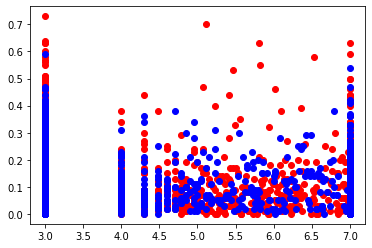

In [388]:
train_NM = get_rfq_params_NM(train_df)
# train_NM["MidPrice"] = (train_NM["MidPrice"] - train_NM["MidPrice"].mean())/train_NM["MidPrice"].std()
plt.scatter(train_NM[train_NM["Bond_Bond_2"]==0]["Notional"], np.absolute(train_NM[train_NM["Bond_Bond_2"]==0]["delta_nextmid"]), color='red')
plt.scatter(train_NM[train_NM["Bond_Bond_2"]==1]["Notional"], np.absolute(train_NM[train_NM["Bond_Bond_2"]==1]["delta_nextmid"]), color='blue')

In [389]:
train,test = get_train_test_data(train_NM,0.8)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = test[:, :-1]
y_test = test[:, -1]

Index(['Notional', 'Competitors', 'Bond_Bond_0', 'Bond_Bond_1', 'Bond_Bond_2',
       'Side_Bid', 'Side_Offer', 'Counterparty_Ctpy_0', 'Counterparty_Ctpy_1',
       'Counterparty_Ctpy_2', 'Counterparty_Ctpy_3', 'delta_nextmid'],
      dtype='object')


In [390]:
# import sklearn.gaussian_process as gp
# kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
# model_gp = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
# model_gp.fit(X_train, y_train)

In [391]:
# params = model_gp.kernel_.get_params()
# y_pred, std = model_gp.predict(X_test, return_std=True)
# gp_MSE = ((y_pred-y_test)**2).mean()

In [392]:
# plt.scatter(y_test, y_pred)

0.016192967575440798


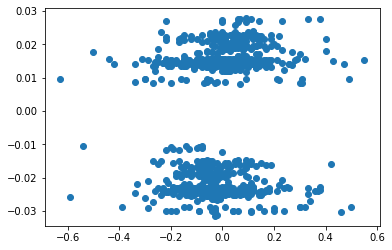

In [393]:
from sklearn import linear_model
BayReg = linear_model.BayesianRidge()
BayReg.fit(X_train, y_train)
y_pred, std = BayReg.predict(X_test, return_std=True)
br_MSE = ((y_pred-y_test)**2).mean()
print(br_MSE)
plt.scatter(y_test, y_pred)

0.016301013754272575


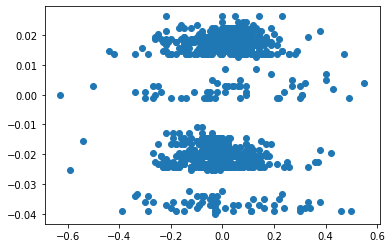

In [394]:
from sklearn import linear_model
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
lr_MSE = ((y_pred-y_test)**2).mean()
print(lr_MSE)
plt.scatter(y_test, y_pred)

0.017709668910897876


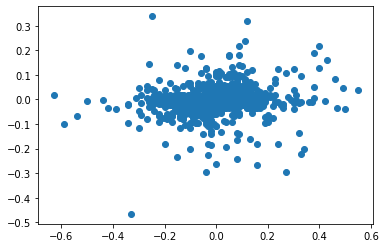

In [395]:
from xgboost import XGBRegressor
model_xgboost = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model_xgboost.fit(X_train, y_train)
y_pred = model_xgboost.predict(X_test)
xg_MSE = ((y_pred-y_test)**2).mean()
print(xg_MSE)
plt.scatter(y_test, y_pred)

0.0158250259200001


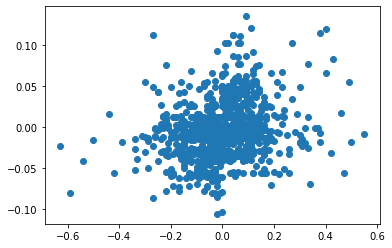

In [396]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=25, metric='cosine')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
knn_MSE = ((y_pred-y_test)**2).mean()
print(knn_MSE)
plt.scatter(y_test, y_pred)

In [438]:
from scipy.optimize import minimize

def loss_function(notional, bid, pred, true):
    loss = 0
    for i in range(len(pred)):
        if (bid[i] == 1 and pred[i] > true[i]) or (bid[i] == 0 and pred[i] < true[i]):
            loss = loss + 10 * (notional[i])**10 * (pred[i] - true[i])**2
        else:
            loss = loss + (notional[i])**10 * (pred[i] - true[i])**2
    return loss
        

def objective_function(beta, X, Y):
    error = loss_function(X[:,0], X[:,5], np.matmul(X,beta), Y) + np.sum(1000*(beta)**2)
    return(error)


beta_init = BayReg.coef_
result = minimize(objective_function, beta_init, args=(X_train,y_train, ),
                  method='BFGS', options={'maxiter': 5000})

In [439]:
train_NM.columns

Index(['Notional', 'Competitors', 'Bond_Bond_0', 'Bond_Bond_1', 'Bond_Bond_2',
       'Side_Bid', 'Side_Offer', 'Counterparty_Ctpy_0', 'Counterparty_Ctpy_1',
       'Counterparty_Ctpy_2', 'Counterparty_Ctpy_3', 'delta_nextmid'],
      dtype='object')

In [440]:
beta_hat = result.x
beta_hat

array([ 0.01301044, -0.0069747 ,  0.01274749, -0.01740598,  0.01671578,
       -0.21468802,  0.10796455, -0.00389018, -0.01586922, -0.04661801,
       -0.03122398])

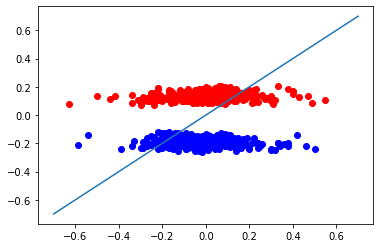

In [441]:
y_pred = np.matmul(X_test,beta_hat)
plt.scatter(y_test[X_test[:,5]==1], y_pred[X_test[:,5]==1], color='blue')
plt.scatter(y_test[X_test[:,5]==0], y_pred[X_test[:,5]==0], color='red')
plt.plot([-0.7,0,0.7],[-0.7,0,0.7])
plt.show()

In [431]:
((y_pred-y_test)**2).mean()

0.016453010277096152